# CFH Test by Bassel Rezk -- Predicting Stock Data

## Data Preprocessing

### Importing Libraries

In [ ]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 720.9 kB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from xgboost import XGBRegressor
from sklearn.svm import SVR
from tensorflow.keras.layers import Dense, Dropout, LSTM, TimeDistributed, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import keras_tuner
import seaborn as sns

### Importing Dataset and Dealing with Missing Values

In [77]:
dataset = pd.read_csv("EGX_DLY_EGX30, 1D.csv")
dataset = dataset.loc[dataset['close'] != 1] #Removing values where close = 1, like in the EMFD dataset, as they are assumed to be missing values

### Feature Selection using Correlation Matrix

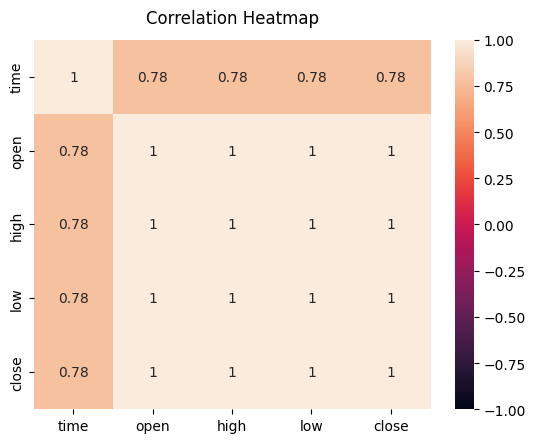

In [78]:
heatmap = sns.heatmap(dataset.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
# The results show that the time column has a very weak correlation to the close value, so it would be omitted
X = dataset.iloc[:, 1:-1].values
y = dataset.iloc[:, -1].values

### Splitting into Training Set and Test Set

In [79]:
#Time series data is split based on sequential means, not random means using train_test_split in sklearn. The test set was chosen to be the final 20% of the datapoints.

X_train, X_test = np.split(X, [int(.80 *len(X))])
y_train, y_test = np.split(y, [int(.80 *len(X))])

### Feature Scaling

In [80]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test) # Scaler is not fitted to test set to avoid overfitting
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

## Training and Evaluating Random Forest Regression model

### Cross-Validation and Hyperparameter Tuning

In [ ]:
ts_split = TimeSeriesSplit(n_splits=20)
RFR_reg_cv = RandomForestRegressor(random_state=0) #Random state added to ensure homogenity of results
params_RFR = {
    'n_estimators': [25, 50, 75, 100, 125, 150],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse'],
}
RFR_gscv = GridSearchCV(RFR_reg_cv, params_RFR, scoring='r2', n_jobs=-1, cv=ts_split)
RFR_gscv.fit(X_train, y_train)
print(f'Best R2 Score: {RFR_gscv.best_score_}')
print(RFR_gscv.best_params_)

Best R2 Score: 0.9161296291463934
{'criterion': 'absolute_error', 'n_estimators': 150}


### RFR Training

In [81]:
#Best parameters found to be 'criterion': 'absolute_error', 'n_estimators': 150
RFR_regressor = RandomForestRegressor(random_state=0, criterion='absolute_error', n_estimators=150)
RFR_regressor.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', n_estimators=150,
                      random_state=0)

### RFR Evaluation

In [82]:
y_pred_rfr = RFR_regressor.predict(X_test)
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)), scaler_y.inverse_transform(y_pred_rfr.reshape(-1, 1)))*100}%')
print(f'R2 Score: {r2_score(scaler_y.inverse_transform(y_test.reshape(-1, 1)), scaler_y.inverse_transform(y_pred_rfr.reshape(-1, 1)))}')

Mean Absolute Percentage Error: 4.075162232555563%
R2 Score: 0.7483814261222522


### Plotting RFR Results vs Actual Closing Values

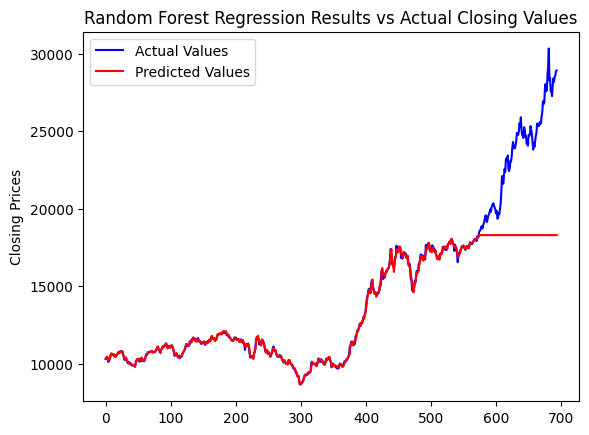

In [83]:
rfr_line_actual = plt.plot(scaler_y.inverse_transform(y_test.reshape(-1, 1)), color='blue', label='Actual Values')
rfr_line_pred = plt.plot(scaler_y.inverse_transform(y_pred_rfr.reshape(-1, 1)), color='red', label='Predicted Values')
plt.ylabel('Closing Prices')
plt.title('Random Forest Regression Results vs Actual Closing Values')
plt.legend()


## Training and Evaluating XGBoost Regression

### Cross-Validation and Hyperparameter Tuning

In [ ]:
xgb_ts_split = TimeSeriesSplit(n_splits=25)
XGB_cv = XGBRegressor(random_state=0)
params_XGB = {
    'eta': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'lambda': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]
}
XGB_search = GridSearchCV(XGB_cv, params_XGB, scoring='r2', n_jobs=-1, cv=xgb_ts_split)
XGB_search.fit(X_train, y_train)
print(f'Best R2 Score: {XGB_search.best_score_}')
print(XGB_search.best_params_)

Best R2 Score: 0.9465042052069542
{'eta': 0.1, 'lambda': 0.2}


### XGB Training

In [84]:
# Best parameters found to be {'eta': 0.1, 'lambda': 0.2}
XGB_regressor = XGBRegressor(eta=0.1, reg_lambda = 0.2, random_state=0)
XGB_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

### XGB Evaluation

In [85]:
y_pred_xgb = XGB_regressor.predict(X_test)
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)), scaler_y.inverse_transform(y_pred_xgb.reshape(-1, 1)))*100}%')
print(f'R2 Score: {r2_score(scaler_y.inverse_transform(y_test.reshape(-1, 1)), scaler_y.inverse_transform(y_pred_xgb.reshape(-1, 1)))}')

Mean Absolute Percentage Error: 4.336194038173459%
R2 Score: 0.7312756608611575


### Plotting XGB Results vs Actual Closing Values

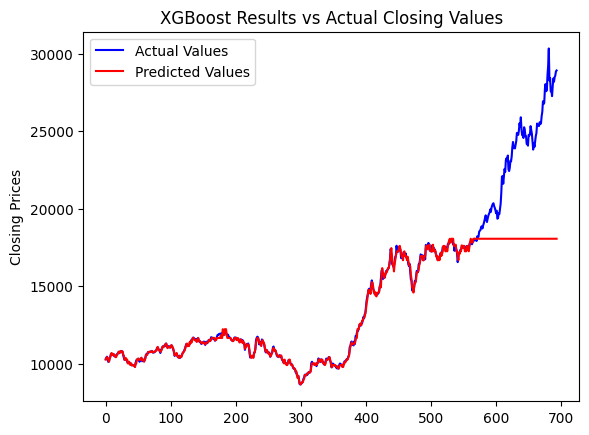

In [86]:
xgb_line_actual = plt.plot(scaler_y.inverse_transform(y_test.reshape(-1, 1)), color='blue', label='Actual Values')
xgb_line_pred = plt.plot(scaler_y.inverse_transform(y_pred_xgb.reshape(-1, 1)), color='red', label='Predicted Values')
plt.ylabel('Closing Prices')
plt.title('XGBoost Results vs Actual Closing Values')
plt.legend()

## Training and Evaluating Support Vector Regression

### Cross-Validation and Hyperparameter Tuning

In [ ]:
params_SVR = [{
                'C': [0.25, 0.5, 0.75, 1],
                'kernel': ['linear'],
              },
              {
                'C': [0.25, 0.5, 0.75, 1],
                'kernel': ['rbf', 'sigmoid'],
                'gamma': [0.1, 0.2, 0.3, 0.4, 0.5],
              }]

svr_ts_split = TimeSeriesSplit(n_splits=25)
svr_cv = SVR()
svr_search = RandomizedSearchCV(svr_cv, params_SVR, cv=svr_ts_split, scoring='r2', n_jobs=-1, n_iter=50)
svr_search.fit(X_train, y_train)
print(f'Best R2 Score: {svr_search.best_score_}')
print(svr_search.best_params_)

Best R2 Score: 0.9783982803039153
{'kernel': 'linear', 'C': 1}


### Training SVR

In [87]:
# Best parameters were found to be 'kernel': 'linear', 'C': 1
svr_regressor = SVR(kernel='linear', C=1)
svr_regressor.fit(X_train, y_train)

SVR(C=1, kernel='linear')

### SVR Evaluation

In [88]:
y_pred_svr = svr_regressor.predict(X_test)
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)), scaler_y.inverse_transform(y_pred_svr.reshape(-1, 1)))*100}%')
print(f'R2 Score: {r2_score(scaler_y.inverse_transform(y_test.reshape(-1, 1)), scaler_y.inverse_transform(y_pred_svr.reshape(-1, 1)))}')

Mean Absolute Percentage Error: 0.9160498822575783%
R2 Score: 0.9981414614601222


### Plotting SVR Results vs Actual Closing Values

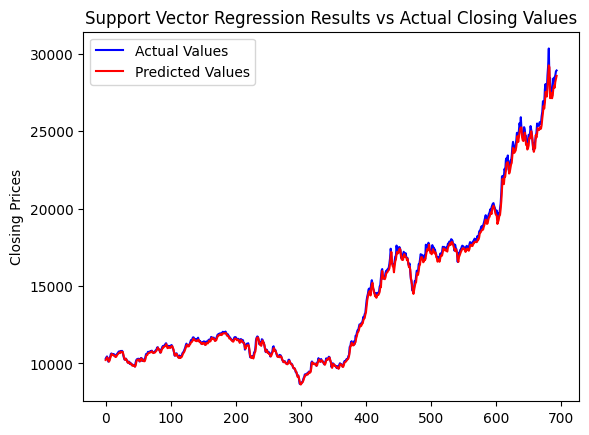

In [89]:
svr_line_actual = plt.plot(scaler_y.inverse_transform(y_test.reshape(-1, 1)), color='blue', label='Actual Values')
svr_line_pred = plt.plot(scaler_y.inverse_transform(y_pred_svr.reshape(-1, 1)), color='red', label='Predicted Values')
plt.ylabel('Closing Prices')
plt.title('Support Vector Regression Results vs Actual Closing Values')
plt.legend()

## Training and Evaluating Long Short Term Memory

### Adjusting X and Y to include timesteps

In [90]:
def prepare_dataset_for_LSTM(df, window_size):
  #This function converts the X and y tensors to be applicable in LSTMs by creating
  #timesteps in the X tensor, and the number of timesteps is the number of timesteps
  #to be used to predict Y. This is known as 'sequence creation'
  df_numpy = df.to_numpy()
  new_X = []
  new_y = []
  for i in range(len(dataset)-window_size):
    row = [j for j in df_numpy[i:i+window_size]]
    new_X.append(row)
    label = df_numpy[i+window_size][-1]
    new_y.append(label)
  return np.array(new_X), np.array(new_y)

window_size = 5
X_LSTM, y_LSTM = prepare_dataset_for_LSTM(dataset, window_size)
X_LSTM = np.delete(X_LSTM, 0, axis=2) #Removing the time variable

X_LSTM.shape

(3462, 5, 4)

### Splitting into Training, Validation and Test Sets & Feature Scaling

In [91]:
#Splitting dataset into 80% training set, 10% validation set, 10% test set
X_train_LSTM, X_test_LSTM = np.split(X_LSTM, [int(.80 *len(X_LSTM))])
X_val_LSTM, X_test_LSTM = np.split(X_test_LSTM, [int(.50 *len(X_test_LSTM))])
y_train_LSTM, y_test_LSTM = np.split(y_LSTM, [int(.80 *len(y_LSTM))])
y_val_LSTM, y_test_LSTM = np.split(y_test_LSTM, [int(.50 *len(y_test_LSTM))])

print(X_train_LSTM)
#Reshaping done to allow Standard Scaling to be applied on a 3D array
Scaler_X_LSTM = StandardScaler()
X_train_LSTM = Scaler_X_LSTM.fit_transform(X_train_LSTM.reshape(-1, X_train_LSTM.shape[-1])).reshape(X_train_LSTM.shape)
X_val_LSTM = Scaler_X_LSTM.transform(X_val_LSTM.reshape(-1, X_val_LSTM.shape[-1])).reshape(X_val_LSTM.shape)
X_test_LSTM = Scaler_X_LSTM.transform(X_test_LSTM.reshape(-1, X_test_LSTM.shape[-1])).reshape(X_test_LSTM.shape)

#Reshaping done to allow Standard Scaling to be applied on a 1D array
Scaler_y_LSTM = StandardScaler()
y_train_LSTM = Scaler_y_LSTM.fit_transform(y_train_LSTM.reshape(-1, 1)).ravel()
y_val_LSTM = Scaler_y_LSTM.transform(y_val_LSTM.reshape(-1, 1)).ravel()
y_test_LSTM = Scaler_y_LSTM.transform(y_test_LSTM.reshape(-1, 1)).ravel()

X_train_LSTM.shape, y_train_LSTM.shape

[[[ 7131.700195  7157.509766  7123.200195  7145.149902]
  [ 7139.060059  7139.290039  7062.069824  7062.089844]
  [ 7042.22998   7101.700195  7002.209961  7101.700195]
  [ 7133.209961  7207.540039  7131.310059  7188.75    ]
  [ 7177.47998   7261.759766  7174.22998   7249.549805]]

 [[ 7139.060059  7139.290039  7062.069824  7062.089844]
  [ 7042.22998   7101.700195  7002.209961  7101.700195]
  [ 7133.209961  7207.540039  7131.310059  7188.75    ]
  [ 7177.47998   7261.759766  7174.22998   7249.549805]
  [ 7240.009766  7240.470215  7189.75      7198.160156]]

 [[ 7042.22998   7101.700195  7002.209961  7101.700195]
  [ 7133.209961  7207.540039  7131.310059  7188.75    ]
  [ 7177.47998   7261.759766  7174.22998   7249.549805]
  [ 7240.009766  7240.470215  7189.75      7198.160156]
  [ 7192.5       7279.910156  7121.160156  7121.160156]]

 ...

 [[10738.4      10786.1      10717.6      10739.7     ]
  [10739.7      10740.5      10565.6      10568.4     ]
  [10568.4      10601.6      10543.8

((2769, 5, 4), (2769,))

### Hyperparameter Tuning

In [7]:
def build_model(hp):
  nn = Sequential()
  nn.add(LSTM(units=hp.Int('units_1', min_value=16, max_value=512, step=16), input_shape=(5,4)))
  nn.add(Dense(units=1))
  nn.compile(optimizer=Adam(hp.Float('learning_rate', min_value=0.001, max_value=0.01, step=0.001)), loss='mean_absolute_percentage_error', metrics=[r2_score], run_eagerly=True)
  return nn

LSTM_tuner = keras_tuner.RandomSearch(build_model, max_epochs=150, objective=keras_tuner.Objective('val_r2_score', direction="max"))
LSTM_tuner.search(X_train_LSTM, y_train_LSTM, validation_data=(X_val_LSTM, y_val_LSTM))
LSTM_tuner.results_summary()

Trial 147 Complete [00h 08m 28s]

Best val_r2_score So Far: 0.5501508116722107
Total elapsed time: 01h 38m 18s

Search: Running Trial #148

Value             |Best Value So Far |Hyperparameter
256               |368               |units_1
0.002             |0.003             |learning_rate
150               |6                 |tuner/epochs
50                |2                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
4                 |1                 |tuner/round
0145              |0052              |tuner/trial_id

Epoch 51/150
36/53 [===================>..........] - ETA: 2s - loss: 40.5964 - r2_score: 0.9819

KeyboardInterrupt: 

### Finding the Optimal Number of Epochs

In [92]:
# Best hyperparameters were found to be units_1 = 368, learning_rate = 0.003
best_hps= LSTM_tuner.get_best_hyperparameters(num_trials=1)[0]

# Building a model to tune the number of epochs with a maximum of 50
model = LSTM_tuner.hypermodel.build(best_hps)
epoch_tuning = model.fit(X_train_LSTM, y_train_LSTM, epochs=50, validation_data=(X_val_LSTM, y_val_LSTM))

r2_epoch = epoch_tuning.history['val_r2_score']
best_epoch = r2_epoch.index(max(r2_epoch)) + 1
print(f'Optimal Number of Epochs: {best_epoch}')


Epoch 1/50
87/87 [==============================] - 13s 153ms/step - loss: 187.6135 - r2_score: 0.9080 - val_loss: 68.7814 - val_r2_score: -16.4117
Epoch 2/50
87/87 [==============================] - 13s 147ms/step - loss: 240.5902 - r2_score: 0.7854 - val_loss: 240.5288 - val_r2_score: -38.5260
Epoch 3/50
87/87 [==============================] - 13s 148ms/step - loss: 152.2864 - r2_score: 0.8094 - val_loss: 370.1154 - val_r2_score: -57.9593
Epoch 4/50
87/87 [==============================] - 13s 147ms/step - loss: 232.3171 - r2_score: 0.9097 - val_loss: 256.8701 - val_r2_score: -5.9340
Epoch 5/50
87/87 [==============================] - 13s 153ms/step - loss: 635.5385 - r2_score: 0.2541 - val_loss: 705.6320 - val_r2_score: -36.1506
Epoch 6/50
87/87 [==============================] - 13s 153ms/step - loss: 1204.4596 - r2_score: 0.4707 - val_loss: 64.2069 - val_r2_score: -1.9399
Epoch 7/50
87/87 [==============================] - 13s 153ms/step - loss: 454.4780 - r2_score: -0.5605 - val

### Training the tuned LSTM model

In [95]:
# Optimal Number of Epochs found to be 17
LSTM_model = LSTM_tuner.hypermodel.build(best_hps)
LSTM_model.fit(X_train_LSTM, y_train_LSTM, epochs=best_epoch, validation_data=(X_val_LSTM, y_val_LSTM))

Epoch 1/47
87/87 [==============================] - 14s 158ms/step - loss: 90.9632 - r2_score: 0.9440 - val_loss: 83.8663 - val_r2_score: -6.5460
Epoch 2/47
87/87 [==============================] - 14s 158ms/step - loss: 770.4047 - r2_score: 0.9582 - val_loss: 81.1326 - val_r2_score: -8.1287
Epoch 3/47
87/87 [==============================] - 14s 159ms/step - loss: 350.5373 - r2_score: 0.8497 - val_loss: 96.8387 - val_r2_score: -20.4440
Epoch 4/47
87/87 [==============================] - 14s 158ms/step - loss: 226.6566 - r2_score: 0.5097 - val_loss: 201.3986 - val_r2_score: -2.8783
Epoch 5/47
87/87 [==============================] - 14s 160ms/step - loss: 363.4952 - r2_score: 0.7355 - val_loss: 1195.6641 - val_r2_score: -290.5256
Epoch 6/47
87/87 [==============================] - 14s 155ms/step - loss: 3677.5635 - r2_score: 0.2643 - val_loss: 152.3143 - val_r2_score: -41.6860
Epoch 7/47
87/87 [==============================] - 13s 154ms/step - loss: 1344.2255 - r2_score: -0.2980 - val

### Evaluating the LSTM model

In [96]:
X_combined_LSTM = np.append(X_val_LSTM, X_test_LSTM, axis=0) # To evaluate the LSTM models for the same range as the other models
y_combined_LSTM = np.append(y_val_LSTM, y_test_LSTM, axis=0)
y_pred_LSTM = LSTM_model.predict(X_combined_LSTM)
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(Scaler_y_LSTM.inverse_transform(y_combined_LSTM.reshape(-1, 1)), Scaler_y_LSTM.inverse_transform(y_pred_LSTM.reshape(-1, 1)))*100}%')
print(f'R2 Score: {r2_score(Scaler_y_LSTM.inverse_transform(y_combined_LSTM.reshape(-1, 1)), Scaler_y_LSTM.inverse_transform(y_pred_LSTM.reshape(-1, 1)))}')

22/22 [==============================] - 1s 32ms/step
Mean Absolute Percentage Error: 3.31961579617482%
R2 Score: 0.9591189816601843


### Plotting LSTM results vs Actual Closing Values

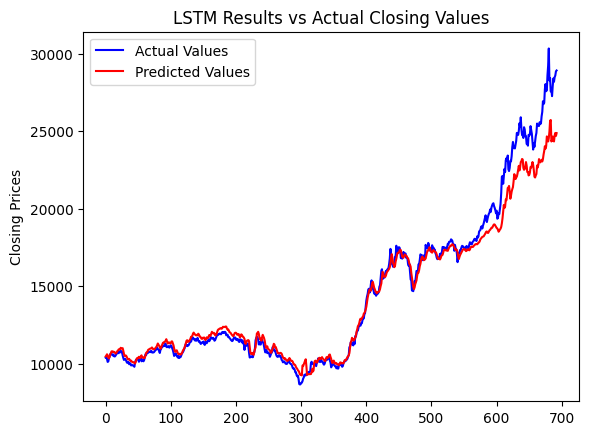

In [97]:
LSTM_line_actual = plt.plot(Scaler_y_LSTM.inverse_transform(y_combined_LSTM.reshape(-1, 1)), color='blue', label='Actual Values')
LSTM_line_predicted = plt.plot(Scaler_y_LSTM.inverse_transform(y_pred_LSTM.reshape(-1, 1)), color='red', label='Predicted Values')
plt.ylabel('Closing Prices')
plt.title('LSTM Results vs Actual Closing Values')
plt.legend()